## Create your own implementation of Learner from scratch, based on the training loop  show  in this chapter.

In [157]:
from fastai.vision.all import *
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from IPython.display import clear_output
from tqdm import tqdm

In [2]:
torch.manual_seed(42)

In [3]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/home/risheek/.fastai/data/mnist_png/training'),Path('/home/risheek/.fastai/data/mnist_png/testing')]

In [4]:
example_path = (path/'training'/'0').ls()[0]
example = Image.open(example_path)
example

## train data

In [5]:
for gpFolder in path.ls():
    if str(gpFolder).split('/')[-1] != 'training':
        break
    labels = [[] for i in range(10)]
    images = [[] for i in range(10)]
    #print(images)
    for idx, labelFolder in enumerate(gpFolder.ls()):
        labels[idx] = torch.stack([tensor(int(str(labelFolder)[-1:])) for i in labelFolder.ls()])
        #print(labels)
        images[idx] = torch.stack([tensor(Image.open(image)) for image in labelFolder.ls()])
        #images = torch.stack([tensor(Image.open(image)) for image in labelFolder.ls()])
        print(f'lable: {str(labelFolder)[-1:]} and # images:{len(images[idx])}')

lable: 2 and # images:5958
lable: 3 and # images:6131
lable: 1 and # images:6742
lable: 7 and # images:6265
lable: 6 and # images:5918
lable: 8 and # images:5851
lable: 4 and # images:5842
lable: 5 and # images:5421
lable: 0 and # images:5923
lable: 9 and # images:5949


In [6]:
labels = torch.cat(labels)
labels.shape

torch.Size([60000])

In [7]:
images = torch.cat(images).view(-1,28*28)
images.shape

torch.Size([60000, 784])

In [8]:
train_x = images.type(torch.float32)
train_y = labels.unsqueeze(1).type(torch.float32)
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [9]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([2.]))

In [10]:
dl = DataLoader(dset, shuffle=True, batch_size=32)
dl

In [11]:
X = next(iter(dl))
X[0].shape, X[1].shape

(torch.Size([32, 784]), torch.Size([32, 1]))

## valid data

In [12]:
for gpFolder in path.ls():
    if str(gpFolder).split('/')[-1] != 'training':
        labels = [[] for i in range(10)]
        images = [[] for i in range(10)]
        #print(images)
        for idx, labelFolder in enumerate(gpFolder.ls()):
            labels[idx] = torch.stack([tensor(int(str(labelFolder)[-1:])) for i in labelFolder.ls()])
            #print(labels)
            images[idx] = torch.stack([tensor(Image.open(image)) for image in labelFolder.ls()])
            #images = torch.stack([tensor(Image.open(image)) for image in labelFolder.ls()])
            print(f'lable: {str(labelFolder)[-1:]} and # images:{len(images[idx])}')

lable: 2 and # images:1032
lable: 3 and # images:1010
lable: 1 and # images:1135
lable: 7 and # images:1028
lable: 6 and # images:958
lable: 8 and # images:974
lable: 4 and # images:982
lable: 5 and # images:892
lable: 0 and # images:980
lable: 9 and # images:1009


In [13]:
labels = torch.cat(labels)
labels.shape

torch.Size([10000])

In [14]:
images = torch.cat(images).view(-1,28*28)
images.shape

torch.Size([10000, 784])

In [15]:
valid_x = images.type(torch.float32)
valid_y = labels.unsqueeze(1).type(torch.float32)
valid_x.shape, valid_y.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

In [16]:
dset = list(zip(valid_x,valid_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([2.]))

In [17]:
valid_dl = DataLoader(dset, shuffle=True, batch_size=32)
valid_dl

In [24]:
X = next(iter(valid_dl))
X[0].shape, X[1].shape

(torch.Size([32, 784]), torch.Size([32, 1]))

In [37]:
len(iter(dl)), len(iter(valid_dl))

(1875, 313)

## model

In [23]:
linear_model = nn.Linear(28*28,10)

In [213]:
layered_model = nn.Sequential(
    nn.Linear(28*28,300),
    nn.ReLU(),
    nn.Linear(300,200),
    nn.ReLU(),
    nn.Linear(200,15),
    nn.ReLU(),
    nn.Linear(15,10)
)

In [187]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([10, 784]), torch.Size([10]))

In [188]:
w1,b1,w2,b2 = layered_model.parameters()
w1.shape, b1.shape, w2.shape, b2.shape

(torch.Size([100, 784]),
 torch.Size([100]),
 torch.Size([10, 100]),
 torch.Size([10]))

In [211]:
def train_model(model, optimizer, epochs, train_dl, valid_dl):
    df = pd.DataFrame()
    for epoch in range(epochs):
        train_loss = 0
        valid_loss = 0
        accuracy = 0
        model.train()
        for data in train_dl:
            train_x = data[0]
            train_y = data[1]
            pred = model(train_x)
            #print(pred.shape, train_y.shape)
            #print(pred)
            loss = F.cross_entropy(pred, train_y.squeeze().type(torch.long))
            #print(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
        train_loss = train_loss/len(train_dl)
        #print(train_loss)
        #print("### END of training loop###")
        model.eval()
        for data in valid_dl:
            valid_x = data[0]
            valid_y = data[1]
            pred = model(valid_x)
            batch_accuracy = torch.where(torch.argmax(pred,1)==valid_y.T,1,0).sum()/len(valid_y)
            accuracy += batch_accuracy
            #print(pred.shape, train_y.shape)
            #print(pred)
            loss = F.cross_entropy(pred, valid_y.squeeze().type(torch.long))
            #print(loss.item())
            valid_loss += loss.item()
        valid_loss = valid_loss/len(valid_dl)
        accuracy = accuracy/len(valid_dl)
        #print(valid_loss, accuracy)
        result = pd.DataFrame.from_dict({
            'epoch': [epoch], 'train_loss':[train_loss], 'valid_loss':[valid_loss], 'accuracy':[accuracy]
        })
        df = pd.concat((df, result), axis=0, ignore_index=True)
        clear_output(wait=True)
        print(df)
    return df

In [190]:
opt = torch.optim.SGD(linear_model.parameters(), lr=0.5)
train_model(linear_model, opt, 100, dl, valid_dl)

    epoch    train_loss    valid_loss        accuracy
0       0  1.437780e+08  1.350720e+08  tensor(0.8808)
1       1  1.436273e+08  1.349186e+08  tensor(0.8809)
2       2  1.434769e+08  1.347953e+08  tensor(0.8808)
3       3  1.433270e+08  1.352032e+08  tensor(0.8809)
4       4  1.431777e+08  1.345316e+08  tensor(0.8813)
..    ...           ...           ...             ...
95     95  1.309563e+08  1.230918e+08  tensor(0.8844)
96     96  1.308357e+08  1.230039e+08  tensor(0.8846)
97     97  1.307153e+08  1.229036e+08  tensor(0.8846)
98     98  1.305955e+08  1.227089e+08  tensor(0.8848)
99     99  1.304755e+08  1.227768e+08  tensor(0.8845)

[100 rows x 4 columns]


In [214]:
opt = torch.optim.Adam(layered_model.parameters(), lr=5e-4)
df = train_model(layered_model, opt, 10, dl, valid_dl)

   epoch  train_loss  valid_loss        accuracy
0      0    0.327564    0.138191  tensor(0.9599)
1      1    0.120530    0.110292  tensor(0.9681)
2      2    0.086866    0.113475  tensor(0.9700)
3      3    0.069176    0.107129  tensor(0.9722)
4      4    0.056066    0.118420  tensor(0.9686)
5      5    0.049354    0.106098  tensor(0.9744)
6      6    0.041721    0.099941  tensor(0.9762)
7      7    0.042259    0.104997  tensor(0.9772)
8      8    0.031230    0.124914  tensor(0.9749)
9      9    0.031673    0.096725  tensor(0.9776)


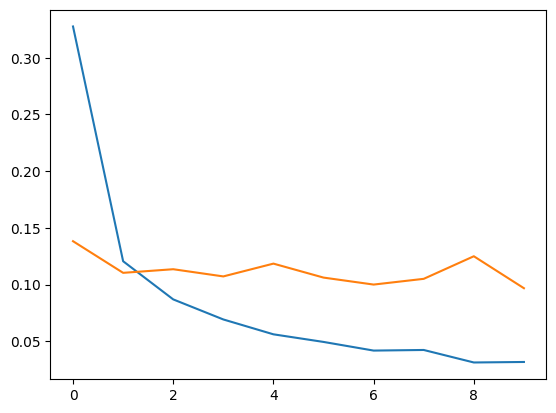

In [216]:
import matplotlib.pyplot as plt
plt.plot(df.train_loss)
plt.plot(df.valid_loss)
plt.show()